In [1]:
from Scripts import Trainings
from Scripts import Plotting
from Scripts import Computing_functions
from Scripts import Plotting_old
from Scripts import Computing_functions_old
import numpy as np
import timeit
import itertools
import importlib
import os
import glob
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import xarray as xr
import re
import seaborn as sns
import ast
import math
sns.set_context('paper') 
OcT = ['Ocean1', 'Ocean2', 'Ocean3', 'Ocean4']
Var_X_BIG_Extra = ['iceDraft', 'bathymetry', 'Slope_iceDraft_x', 'Slope_bathymetry_x',
                   'Slope_iceDraft_y', 'Slope_bathymetry_y', 'Big_T', 'Big_S',
                  'Distances_ground_line', 'Distances_front_line']
Var_X_BIG_Slope = ['iceDraft', 'bathymetry', 'Slope_iceDraft', 'Slope_bathymetry', 'Big_T', 'Big_S',
                  'Distances_ground_line', 'Distances_front_line']
Var_X_slopexy = ['iceDraft', 'bathymetry', 'Slope_iceDraft_x', 'Slope_bathymetry_x',
                   'Slope_iceDraft_y', 'Slope_bathymetry_y', 'temperatureYZ', 'salinityYZ',
                  'Distances_ground_line', 'Distances_front_line']

OcTPlus = ['Ocean1', 'Ocean2', 'Ocean3', 'Ocean4', 'CPL_EXP10_rst']
CPLs_test = ['CPL_EXP10_rst', 'CPL_EXP22_rst', 'CPL_EXP23_rst']

ALL_EXP = ['CPL_EXP10_rst','CPL_EXP11_rst', 'CPL_EXP12_rst','CPL_EXP13_rst','CPL_EXP20_rst','CPL_EXP21_rst','CPL_EXP22_rst', 'CPL_EXP23_rst']
Train_oc_exp = ['Ocean1', 'Ocean2', 'Ocean3', 'Ocean4', 'CPL_EXP10_rst','CPL_EXP13_rst', 'CPL_EXP22_rst', 'CPL_EXP23_rst']

Var_X_non_position_driving = ['thermalDriving', 'halineDriving', 'iceDraft']
Var_X_non_position = ['temperatureYZ', 'salinityYZ', 'iceDraft']
NEW = ['IceOcean1r_ElmerIce', 'IceOcean1ra_ElmerIce']
NEW_under100supr = ['IceOcean1r_ElmerIce_under100supr', 'IceOcean1ra_ElmerIce_under100supr']
NEW_fill100 = ['IceOcean1r_ElmerIce_fill100', 'IceOcean1ra_ElmerIce_fill100']
importlib.reload(Plotting)
importlib.reload(Computing_functions)
importlib.reload(Plotting_old)
importlib.reload(Computing_functions_old)
importlib.reload(Trainings)


2022-07-11 17:18:15.250825: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-11 17:18:15.250887: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


PWD : /home/bouissob/Code
PWD : /home/bouissob/Code


<module 'Scripts.Trainings' from '/home/bouissob/Code/Scripts/Trainings.py'>

In [2]:
(1 - np.around(np.linspace(1, 10, 16, endpoint = False), decimals = 2) ** 2 / 100)[::-1]


array([0.108864, 0.211456, 0.309439, 0.399375, 0.483039, 0.561756,
       0.632764, 0.6975  , 0.755964, 0.808156, 0.854839, 0.894375,
       0.927639, 0.955056, 0.975664, 0.99    ])

In [2]:
Tar = ['CPL_EXP11_rst', 'CPL_EXP12_rst']
NN_attributes = {'Ocean' : OcT, 'Extra_n' : 'Seed_Benchmark'}
li = Computing_functions.Compute_general_benchmark(Var_to_bench='Random_seed', 
            Ocean_target = OcT, NN_attributes=NN_attributes, message = False)

Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1657113609_Ex_Seed_Benchmark, ( 1 / 4)


2022-07-07 15:27:20.253841: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-07 15:27:20.253905: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-07 15:27:20.253947: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (luke60): /proc/driver/nvidia/version does not exist
2022-07-07 15:27:20.254722: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1657116527_Ex_Seed_Benchmark, ( 2 / 4)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1657119428_Ex_Seed_Benchmark, ( 3 / 4)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1657122304_Ex_Seed_Benchmark, ( 4 / 4)


In [6]:
Tar = ['CPL_EXP11_rst', 'CPL_EXP12_rst']
NN_attributes = {'Ocean' : Train_oc_exp, 'Extra_n' : 'Prune_benchmark_Composite'}
li = Computing_functions.Compute_general_benchmark(Var_to_bench='target_sparsity', 
            Ocean_target = ['CPL_EXP11_rst', 'CPL_EXP12_rst'], NN_attributes=NN_attributes, message = False)

Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_128_128_128_128_128_Ch_0-1656251884_Ex_Prune_benchmark_Composite, ( 1 / 17)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_128_128_128_128_128_Ch_0-1656257626_Ex_Prune_benchmark_Composite, ( 2 / 17)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_128_128_128_128_128_Ch_0-1656263189_Ex_Prune_benchmark_Composite, ( 3 / 17)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_128_128_128_128_128_Ch_0-1656315088_Ex_Prune_benchmark_Composite, ( 4 / 17)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP

In [4]:
NN_attributes = {'Ocean' : OcT, 'Extra_n' : 'Fraction_dataset_Benchmark'}
li = Computing_functions.Compute_general_benchmark(Var_to_bench='Fraction', 
            Ocean_target = OcT, NN_attributes=NN_attributes, message = False)

Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1656516407_Ex_Fraction_dataset_Benchmark, ( 1 / 49)


2022-07-06 11:22:35.658291: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-06 11:22:35.658349: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-06 11:22:35.658388: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (luke60): /proc/driver/nvidia/version does not exist
2022-07-06 11:22:35.659124: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1656498295_Ex_Fraction_dataset_Benchmark, ( 2 / 49)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1656520425_Ex_Fraction_dataset_Benchmark, ( 3 / 49)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1656523604_Ex_Fraction_dataset_Benchmark, ( 4 / 49)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1656526522_Ex_Fraction_dataset_Benchmark, ( 5 / 49)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1656529122_Ex_Fraction_dataset_Benchmark, ( 6 / 49)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1656531288_Ex_Fraction_dataset_Benchmark, ( 7 / 49)
Mode

PWD : /home/bouissob/Code
Model used : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1/Ep_8_N_32_64_32_Ch_0-1653384123_Ex_Drivingvsinterp/model_8.h5
Done computing for Ocean1 in : 0 s
Done computing for Ocean2 in : 0 s
Done computing for Ocean3 in : 1 s
Done computing for Ocean4 in : 1 s


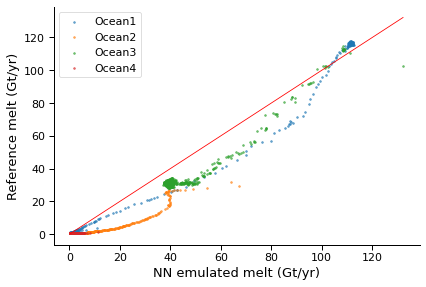

7.69097192431995


In [53]:
importlib.reload(Plotting)
importlib.reload(Computing_functions)
importlib.reload(Trainings)

Mod = [{'Ocean' : 'Ocean1', 'Var' : Var_X_non_position_driving, 'Epoch' : 8, 'Extra_n' : 'Drivingvsinterp'}]
for m in Mod:
    RMSEs, Melts, Modded_Melts = Plotting.Plot_Melt_to_Modded_melt(save = False, 
        Save_name = '', Ocean_target = OcT, NN_attributes = m, Display_label = False, Display_title = False)

PWD : /home/bouissob/Code
Model used : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1/Ep_8_N_32_64_32_Ch_0-1653384123_Ex_Drivingvsinterp/model_8.h5
239
Done computing for Ocean1 in : 18 s
239
Done computing for Ocean2 in : 17 s
1199
Done computing for Ocean3 in : 91 s
1199
Done computing for Ocean4 in : 91 s


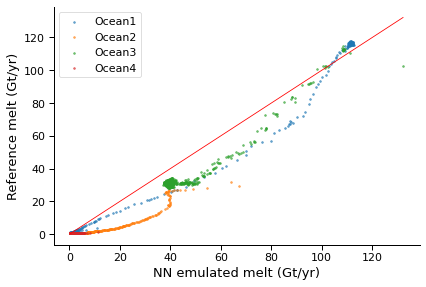

7.69097192431995


In [57]:
importlib.reload(Plotting)
importlib.reload(Computing_functions)
importlib.reload(Trainings)
Mod = [{'Ocean' : 'Ocean1', 'Var' : Var_X_non_position_driving, 'Epoch' : 8, 'Extra_n' : 'Drivingvsinterp'}]
for m in Mod:
     RMSEs3, Melts3, Modded_Melts3 = Plotting.Plot_Melt_to_Modded_melt(save = False, 
        Save_name = '', Ocean_target = OcT, NN_attributes = m, Display_label = False, Display_title = False, recursive_t = True)

In [28]:
print(Melts[0][0:5][0:3], Melts2[0:5][0:3])
print(Modded_Melts[0][0:5][0:3], Modded_melts2[0:5][0:3])


[3.745597456647187, 2.7133308536640057, 2.3177190037071305] [3.74559746 2.71333085 2.317719  ]
[11.111973625179381, 6.434877411061898, 4.8968980255723] [11.11197363  6.43487741  4.89689803]


In [34]:
Melts2

array([3.74559746, 2.71333085, 2.317719  , ..., 0.54365123, 0.55686716,
       0.54879381])

In [49]:
importlib.reload(Plotting_old)
importlib.reload(Computing_functions_old)
importlib.reload(Trainings)

PWD : /home/bouissob/Code


<module 'Scripts.Trainings' from '/home/bouissob/Code/Scripts/Trainings.py'>

['/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1/Ep_8_N_32_64_32_Ch_0-1653384123_Ex_Drivingvsinterp']
Data variables used : thermalDriving halineDriving iceDraftngvsinterp                                                   
Data variables used : thermalDriving halineDriving iceDraft
Data variables used : thermalDriving halineDriving iceDraft
Data variables used : thermalDriving halineDriving iceDraft


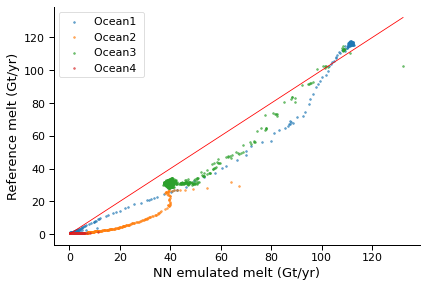

7.690971865008122


In [50]:

Mod = [{'Ocean' : 'Ocean1', 'Var' : Var_X_non_position_driving, 'Epoch' : 8, 'Extra_n' : 'Drivingvsinterp'}]
for m in Mod:
    RMSEs2, Params, Melts2, Modded_melts2, Neurs, Oc_mask = Plotting_old.Plot_Melt_to_Modded_melt(save = False, 
        Save_name = '', Ocean_target = OcT, NN_attributes = m, Display_label = False, Display_title = False)

In [18]:
Melts2

array([3.74559746, 2.71333085, 2.317719  , ..., 0.54365123, 0.55686716,
       0.54879381])

In [21]:
Computing_functions.Flatten_list_list(Melts)

array([3.74559746, 2.71333085, 2.317719  , ..., 0.55686716, 0.54879381,
       0.55239589])

In [67]:
print(Melts[0][0:5][0], Melts2[0:5][0])
print(Modded_Melts[0][0:5][0], Modded_melts2[0:5][0])


3.745597456647187 3.745597456647187
11.111973255757475 11.111973625179381


In [42]:
Computing_functions.Flatten_list_list(Melts).mean()

20.326628259782336

In [43]:
Melts2.mean()

20.303069729001727

In [ ]:
7.693965209536431 # Old method 
7.693965268907425 # New method while looping on every t


7.69097192431995 # New method one compute
7.690971923005611 # Float64 method thingy

7.690971865008122


In [18]:
Modded_melts2

array([11.11197363,  6.43487741,  4.89689803, ...,  0.33851504,
        0.36344711,  0.34471217])

In [10]:
Composite = ['Ocean1', 'Ocean2', 'Ocean3', 'Ocean4', 'CPL_EXP10_rst','CPL_EXP13_rst', 'CPL_EXP22_rst', 'CPL_EXP23_rst']
Ocean_tar = ['CPL_EXP11_rst', 'CPL_EXP12_rst']
Composite_id = 1653216190
NN_attributes = {'Ocean' : Composite, 'Extra_n' : '', 'Uniq_id' : Composite_id}
li = Computing_functions.Compute_general_benchmark(Var_to_bench='Neur_seq', 
            Ocean_target = Ocean_tar, NN_attributes=NN_attributes)

Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_128_N_128_128_128_128_128_Ch_0-1653216190_Ex_, ( 1 / 1)
Model used : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_128_N_128_128_128_128_128_Ch_0-1653216190_Ex_/model_128.h5
Done computing for CPL_EXP11_rst in : 42 s
Done computing for CPL_EXP12_rst in : 42 s


In [2]:
p = '/bettik/bouissob/Method_Data/COM_NEMO-CNRS/Method_3/Ocean1.csv'
df = pd.read_csv(p)
T = [0, 2, 120, 239]
df2 = df.loc[df.date.isin(T)]
df2.head()

,y,x,meltRate,thermalDriving,halineDriving,iceDraft,bathymetry,date,Distances_ground_line,Distances,Distances_front_line,Slope_iceDraft,Slope_iceDraft_x,Slope_iceDraft_y,Slope_bathymetry,Slope_bathymetry_x,Slope_bathymetry_y,temperatureYZ,salinityYZ
0,1000.0,515000.0,1.445518e-09,0.009086,0.127754,82.815510,124.00000,0,2000.0,2000.0,2000.0,0.000000,0.0,0.000000,17.934357,17.934357,0.000000,-1.900030,33.893150
1,1000.0,637000.0,2.533100e-09,0.013837,0.194261,91.276440,579.32086,0,124000.0,124000.0,2000.0,7.109749,0.0,-7.109749,40.295700,-40.289978,-0.679138,-1.900030,33.893150
2,3000.0,515000.0,1.421181e-09,0.008926,0.125516,81.651650,124.00000,0,2000.0,2000.0,2000.0,0.000000,0.0,0.000000,18.584671,17.441551,6.417343,-1.900030,33.889171
3,3000.0,615000.0,2.025993e-09,0.012627,0.177358,89.908270,393.43146,0,102000.0,102000.0,2000.0,8.020058,0.0,-8.020058,28.304410,-28.295593,-0.706451,-1.900036,33.892456
4,3000.0,617000.0,1.932426e-09,0.012012,0.168752,90.281364,407.81378,0,104000.0,104000.0,2000.0,8.546814,0.0,-8.546814,26.577932,-26.568542,-0.706451,-1.900036,33.892456


/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_32_N_32_32_96_96_Ch_0-1656189840_Ex_First_prune
/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_32_N_32_32_96_96_Ch_0-1656173410_Ex_First_prune
/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_32_N_32_32_96_96_Ch_0-1656185286_Ex_First_prune
/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_32_N_32_32_96_96_Ch_0-1656173420_Ex_First_prune
/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_32_N_32_32_96_96_Ch_0-1656177874_Ex_First_prune


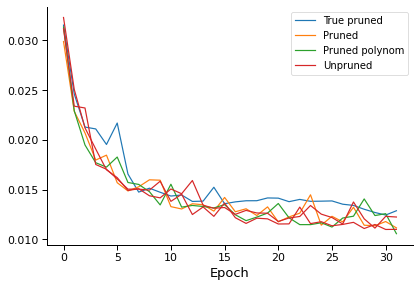

In [29]:
Mod = [{'Ocean' : OcT, 'Uniq_id' :  1656189840}, {'Ocean' : OcT, 'Uniq_id' :  1656173410}, 
       {'Ocean' : OcT, 'Uniq_id' : 1656185286} ,
       {'Ocean' : OcT, 'Uniq_id' : 1656173420}, {'Ocean' : OcT, 'Uniq_id':  1656177874},
      ]#{'Ocean' : OcT, 'Uniq_id' : 1653041657}]
Plotting.Plot_Loss_against_loss(Mods = Mod, Desired_comparaison=['val_mse'], save = False, Desired_length=64,
                                label = ['True pruned', 'Pruned', 'Pruned polynom' , 'Unpruned', 'Unpruned'])
#                label = ['No lr changes', 'Lr /5 every 8', 'Lr /2 every 10', 'lr plateau'])
#label = ['No lr changes', 'Lr /5 every 8', 'Lr /2 every 10', 'lr plateau']

In [7]:
importlib.reload(Plotting)
importlib.reload(Computing_functions)
importlib.reload(Trainings)

PWD : /home/bouissob/Code


<module 'Scripts.Trainings' from '/home/bouissob/Code/Scripts/Trainings.py'>

In [10]:
NN_attributes = {'Ocean' : OcT, 'Pruning' : True, 'Extra_n' : 'Prune_benchmark_ISOMIP'}
li = Computing_functions.Compute_general_benchmark(Var_to_bench='target_sparsity', 
            Ocean_target = OcT, NN_attributes=NN_attributes, message = False)

Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1656196107_Ex_Prune_benchmark_ISOMIP, ( 1 / 14)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1656199271_Ex_Prune_benchmark_ISOMIP, ( 2 / 14)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1656202354_Ex_Prune_benchmark_ISOMIP, ( 3 / 14)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1656205406_Ex_Prune_benchmark_ISOMIP, ( 4 / 14)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1656208454_Ex_Prune_benchmark_ISOMIP, ( 5 / 14)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1656211494_Ex_Prune_benchmark_ISOMIP, ( 6 / 14)
Model : /home/bouissob/Code/

In [9]:
li

,target_sparsity,Overall_RMSE,Ocean1,Ocean2,Ocean3,Ocean4
0,0.108864,0.310873,0.556773,0.178794,0.402704,0.037126
1,0.211456,0.326101,0.584092,0.232912,0.417401,0.043750
2,0.309439,0.317902,0.549404,0.216699,0.413957,0.037770
3,0.399375,0.341471,0.629093,0.261854,0.428625,0.057106
4,0.483039,0.357784,0.643168,0.255102,0.458229,0.038728
5,0.561756,0.351496,0.632008,0.236125,0.450980,0.045794
6,0.632764,0.366792,0.627286,0.321292,0.470077,0.050707
7,0.697500,0.361963,0.611449,0.226899,0.477060,0.042236
8,0.755964,0.396918,0.681732,0.353765,0.508091,0.044352
9,0.808156,0.386278,0.670858,0.304077,0.497448,0.046349


In [15]:
li

([0.10886400000000007,
  0.21145599999999987,
  0.3094389999999998,
  0.39937500000000004,
  0.4830389999999999,
  0.5617559999999999,
  0.6327640000000001,
  0.6975,
  0.755964,
  0.808156,
  0.854839,
  0.894375,
  0.927639,
  0.955056],
 array([0.78315928, 0.55552703, 0.69856836, 0.09028847]),
 [0.31100575419414234,
  0.32606946433388523,
  0.3179573328676505,
  0.3413294890463412,
  0.35771416069448053,
  0.351657300049863,
  0.3668859100221776,
  0.3621135165067872,
  0.3971450228805684,
  0.3865177412624646,
  0.41599239967041346,
  0.4576605267172683,
  0.4781746475153181,
  0.5324090766694376])

In [ ]:
NN_attributes = {'Ocean' : Composite, 'Pruning' : True, 'Extra_n' : 'Prune_benchmark_Composite'}
li = Computing_functions.Compute_general_benchmark(Var_to_bench='target_sparsity', 
            Ocean_target = Ocean_tar, NN_attributes=NN_attributes, message = False)

Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_128_128_128_128_128_Ch_0-1656251884_Ex_Prune_benchmark_Composite, ( 1 / 17)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_128_128_128_128_128_Ch_0-1656257626_Ex_Prune_benchmark_Composite, ( 2 / 17)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_128_128_128_128_128_Ch_0-1656263189_Ex_Prune_benchmark_Composite, ( 3 / 17)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_128_128_128_128_128_Ch_0-1656315088_Ex_Prune_benchmark_Composite, ( 4 / 17)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP

In [31]:
li

([0.10886400000000007,
  0.21145599999999987,
  0.3094389999999998,
  0.10886400000000007,
  0.21145599999999987,
  0.3094389999999998],
 [array([9.04985956, 5.75312943]),
  array([14.49959684,  6.99669998]),
  array([14.02631611,  6.23662086]),
  array([13.88904444,  9.93929288]),
  array([8.78758289, 5.7674999 ]),
  array([10.78477635,  7.50120527])],
 [7.582824548090971,
  11.384026510041323,
  10.854330551556211,
  12.076735868421126,
  7.4325523278613534,
  9.2892271283883])

In [9]:
NN_attributes = {'Ocean' : Composite, 'Pruning' : True, 'Extra_n' : 'Prune_benchmark_Composite'}
Trainings.Get_model_path_json(**NN_attributes, return_all = True)

['/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_128_128_128_128_128_Ch_0-1656251884_Ex_Prune_benchmark_Composite',
 '/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_128_128_128_128_128_Ch_0-1656257626_Ex_Prune_benchmark_Composite',
 '/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_128_128_128_128_128_Ch_0-1656263189_Ex_Prune_benchmark_Composite']

In [39]:
importlib.reload(Plotting)
importlib.reload(Computing_functions)
importlib.reload(Trainings)


PWD : /home/bouissob/Code


<module 'Scripts.Trainings' from '/home/bouissob/Code/Scripts/Trainings.py'>

In [28]:
NN_attributes = {'Ocean' : Composite, 'Pruning' : False, 'Extra_n' : 'Complexity_downgrade_composite'}
li = Computing_functions.Compute_general_benchmark(Var_to_bench='Neur_seq', 
            Ocean_target = Ocean_tar, NN_attributes=NN_attributes, message = False)

Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_96_96_96_96_96_Ch_0-1656318593_Ex_Complexity_downgrade_composite, ( 1 / 3)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_32_32_96_96_Ch_0-1656323971_Ex_Complexity_downgrade_composite, ( 2 / 3)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_96_96_96_96_96_Ch_0-1656330067_Ex_Complexity_downgrade_composite, ( 3 / 3)


In [32]:
import time
p = '/home/bouissob/Code/Cached_data/Generic_benchmark/'
Interest = 'Neur_seq'
pd.DataFrame.to_csv(li, p + f'{Interest}_{int(time.time())}.csv', index = False)

In [37]:
Composite_id = 1653216190
NN_attributes = {'Ocean' : Composite, 'Extra_n' : '', 'Uniq_id' : Composite_id}
li = Computing_functions.Compute_general_benchmark(Var_to_bench='Neur_seq', 
            Ocean_target = Ocean_tar, NN_attributes=NN_attributes, message = False)

Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_128_N_128_128_128_128_128_Ch_0-1653216190_Ex_, ( 1 / 1)


In [27]:
li

,Neur_seq,Overall_RMSE,CPL_EXP11_rst,CPL_EXP12_rst
0,128_128_128_128_128,12.021785,14.757393,8.441917


0.10886400000000007
Ep_64_N_128_128_128_128_128_Ch_0-1656251884_Ex_Prune_benchmark_Composite


<Figure size 432x288 with 0 Axes>

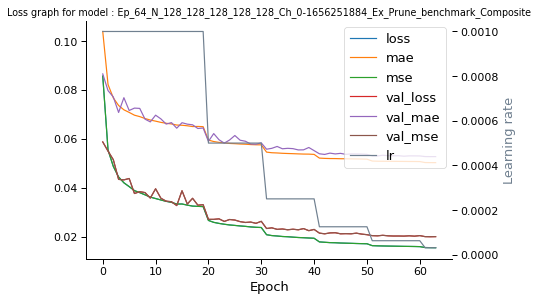

0.21145599999999987
Ep_64_N_128_128_128_128_128_Ch_0-1656251884_Ex_Prune_benchmark_Composite


<Figure size 432x288 with 0 Axes>

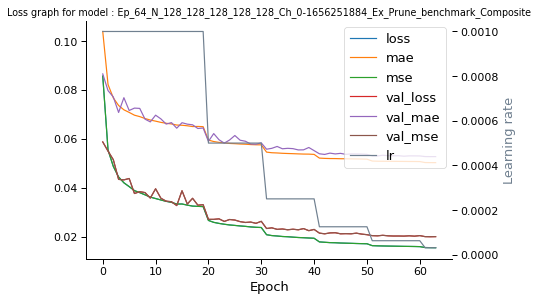

0.3094389999999998
Ep_64_N_128_128_128_128_128_Ch_0-1656251884_Ex_Prune_benchmark_Composite


<Figure size 432x288 with 0 Axes>

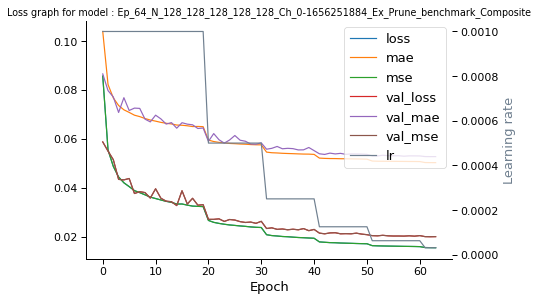

0.10886400000000007
Ep_64_N_128_128_128_128_128_Ch_0-1656251884_Ex_Prune_benchmark_Composite


<Figure size 432x288 with 0 Axes>

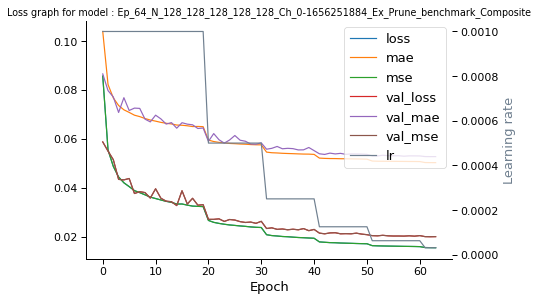

0.21145599999999987
Ep_64_N_128_128_128_128_128_Ch_0-1656251884_Ex_Prune_benchmark_Composite


<Figure size 432x288 with 0 Axes>

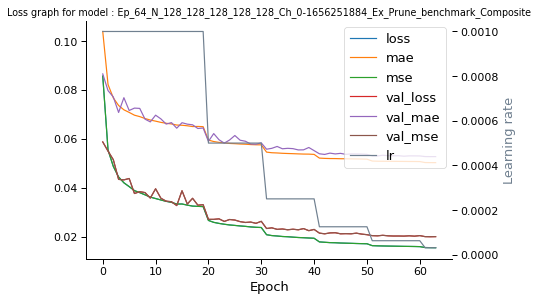

0.3094389999999998
Ep_64_N_128_128_128_128_128_Ch_0-1656251884_Ex_Prune_benchmark_Composite


<Figure size 432x288 with 0 Axes>

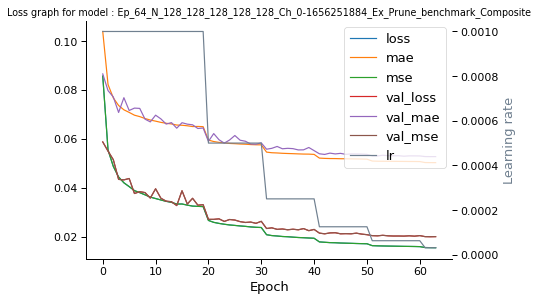

In [42]:
NN_attributes = {'Ocean' : Composite, 'Pruning' : True, 'Extra_n' : 'Prune_benchmark_Composite'}
ps = Trainings.Get_model_path_json(**NN_attributes, return_all = True)
for p in ps:
    plt.figure()
    Config = Trainings.Get_model_attributes(p)
    att = {'Ocean' : OcT, 'Uniq_id' : Config['Uniq_id']}
    print(Config['target_sparsity'])
    Plotting.Plot_loss_model(Second_axis=['lr'], **NN_attributes)